In [444]:
import pandas as pd
import numpy as np
from dateutil.relativedelta import *
import seaborn as sns
from pandas import DataFrame
import datetime

# Import necessary libraries
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn import preprocessing


## Load factors and limit data file to only those we want to focus on

In [445]:
factors_load = pd.read_csv(r'C:\Users\anoble\Git\Outside_Work\AFL Fantasy\Data\Inputs\factors.csv')\

## Remove columns that could be null in 2023, and player names
factors_prep = factors_load.drop(['matches_y','year_int','predicted_year'], axis = 1)

## Split out 2023 factors to run through model
factors_prep_23 = factors_prep.query('year_played == 2023').drop(['avg_score'], axis = 1)

# # Drop nulls (165 rows dropped, leaving 2837 after removing Nulls)
factors_prep = factors_prep.dropna(axis= 0, how='any')
factors_prep_23 = factors_prep_23.dropna(axis= 0, how='any')

## Remove Player Name so it doesn't treat as dummy variable
factors = factors_prep.drop(['player_name'], axis = 1)
factors_23 = factors_prep_23.drop(['player_name'], axis = 1)

# # ## Convert position variables into category column. COuld also consider category_encoders sklearn package
factors['position_grouped'] = factors['position_grouped'].astype('category')
factors['position_grouped_simple'] = factors['position_grouped_simple'].astype('category')

factors_23['position_grouped'] = factors_23['position_grouped'].astype('category')
factors_23['position_grouped_simple'] = factors_23['position_grouped_simple'].astype('category')

# ## One hot encoding to convert category variables into dummy columns
factors = pd.get_dummies(factors)

factors_23 = pd.get_dummies(factors_23)


print(factors.shape)
print(factors_23.shape)


(2205, 186)
(483, 185)


In [446]:
factors = factors[[
    'avg_score'
    ,'age_1yr'
    ,'years_active'
    ,'player_height_cm_1yr'
    ,'player_weight_kg_1yr'
    # ,'afl_fantasy_score_1yr'
    # ,'afl_fantasy_score_3yr'
    # ,'afl_fantasy_score_5yr'
    ,'fantasy_score_yearly_change'
    ,'fantasy_score_yearly_change_exp'
    ,'fantasy_score_inyear_change'
    ,'kicks_1yr'
    ,'marks_1yr'
    ,'handballs_1yr'
    # ,'disposals_1yr'
    # ,'position_grouped_BP'
    # ,'position_grouped_C'
    # ,'position_grouped_CHB'
    # ,'position_grouped_CHF'
    # ,'position_grouped_FB'
    # ,'position_grouped_FF'
    # ,'position_grouped_FP'
    # ,'position_grouped_HBF'
    # ,'position_grouped_HFF'
    # ,'position_grouped_RUCK'
    # ,'position_grouped_W'
    ,'position_grouped_simple_Key_Position'
    ,'position_grouped_simple_Centres'
    ,'position_grouped_simple_Wings_Flank'
    ,'position_grouped_simple_Ruck'
    # ,'effective_disposals_1yr'
    # ,'disposal_efficiency_percentage_1yr'
    ,'goals_1yr'
    ,'behinds_1yr' 
    ,'hitouts_1yr'
    ,'tackles_1yr'
    # ,'rebounds_1yr'
    # ,'inside_fifties_1yr'
    # ,'clearances_1yr'
    # ,'clangers_1yr'
    ,'free_kicks_for_1yr'
    ,'free_kicks_against_1yr'
    # ,'brownlow_votes_1yr'
    ,'contested_possessions_1yr'
    ,'uncontested_possessions_1yr'
    # ,'contested_marks_1yr'
    # ,'marks_inside_fifty_1yr'
    # ,'one_percenters_1yr'
    # ,'bounces_1yr'
    # ,'goal_assists_1yr'
    ,'time_on_ground_percentage_1yr'
    ,'centre_clearances_1yr'
    ,'stoppage_clearances_1yr'
    # ,'score_involvements_1yr'
    # ,'metres_gained_1yr'
    # ,'turnovers_1yr'
    # ,'intercepts_1yr'
    # ,'tackles_inside_fifty_1yr'
    # ,'contest_def_losses_1yr'
    # ,'contest_def_one_on_ones_1yr'
    # ,'contest_off_one_on_ones_1yr'
    # ,'contest_off_wins_1yr'
    # ,'def_half_pressure_acts_1yr'
    ,'effective_kicks_1yr'
    # ,'f50_ground_ball_gets_1yr'
    ,'ground_ball_gets_1yr'
    # ,'hitouts_to_advantage_1yr'
    # ,'hitout_win_percentage_1yr'
    # ,'intercept_marks_1yr'
    # ,'marks_on_lead_1yr'
    # ,'pressure_acts_1yr'
    ,'rating_points_1yr'
    # ,'ruck_contests_1yr'
    # ,'score_launches_1yr'
    # ,'shots_at_goal_1yr'
    # ,'spoils_1yr'
]]

factors

,avg_score,age_1yr,years_active,player_height_cm_1yr,player_weight_kg_1yr,fantasy_score_yearly_change,fantasy_score_yearly_change_exp,fantasy_score_inyear_change,kicks_1yr,marks_1yr,...,free_kicks_for_1yr,free_kicks_against_1yr,contested_possessions_1yr,uncontested_possessions_1yr,time_on_ground_percentage_1yr,centre_clearances_1yr,stoppage_clearances_1yr,effective_kicks_1yr,ground_ball_gets_1yr,rating_points_1yr
1,114.619048,26.0,7,182.0,87.0,0.000000,0.0,-11.541667,19.450000,3.050000,...,2.050000,1.400000,14.900000,18.400000,92.450000,3.000000,3.600000,11.736842,10.684211,21.370000
2,122.857143,26.0,7,182.0,87.0,-4.917538,0.0,-14.472727,16.333333,3.476190,...,1.666667,1.190476,14.904762,15.857143,94.142857,2.380952,3.523810,9.380952,11.380952,20.085714
3,109.000000,26.0,7,182.0,87.0,2.475325,0.0,12.977778,17.071429,2.071429,...,2.428571,1.500000,18.357143,14.071429,93.000000,3.500000,4.785714,10.500000,14.071429,23.250000
4,101.214286,26.0,7,182.0,87.0,-7.800000,0.0,72.500000,18.000000,2.000000,...,3.000000,1.800000,12.800000,13.000000,88.000000,3.200000,4.000000,13.400000,8.400000,24.160000
5,118.785714,26.0,7,182.0,87.0,-10.361472,0.0,2.466667,14.500000,2.000000,...,1.357143,1.357143,13.214286,13.571429,87.500000,3.071429,4.357143,9.153846,9.923077,15.778571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5206,85.111111,26.0,8,189.0,88.0,-4.579787,0.0,-1.483333,7.166667,3.583333,...,0.750000,0.875000,7.583333,8.500000,83.625000,0.916667,1.125000,3.869565,5.521739,7.570833
5207,76.153846,26.0,8,189.0,88.0,5.271825,0.0,-8.500000,8.000000,3.777778,...,0.555556,0.888889,9.111111,9.666667,81.555556,1.000000,2.000000,4.777778,7.222222,10.344444
5209,78.000000,26.0,8,189.0,88.0,-6.536866,0.0,0.555556,4.642857,2.785714,...,0.428571,1.000000,5.642857,8.857143,80.785714,0.214286,0.714286,3.285714,4.928571,9.357143
5211,49.666667,26.0,8,189.0,88.0,0.000000,0.0,-5.333333,6.000000,3.200000,...,0.300000,0.500000,6.200000,8.700000,79.900000,0.300000,1.000000,3.900000,4.700000,7.710000


In [447]:
factors_23 = factors_23[[
       'age_1yr'
    ,'years_active'
    ,'player_height_cm_1yr'
    ,'player_weight_kg_1yr'
    # ,'afl_fantasy_score_1yr'
    # ,'afl_fantasy_score_3yr'
    # ,'afl_fantasy_score_5yr'
    ,'fantasy_score_yearly_change'
    ,'fantasy_score_yearly_change_exp'
    ,'fantasy_score_inyear_change'
    ,'kicks_1yr'
    ,'marks_1yr'
    ,'handballs_1yr'
    # ,'disposals_1yr'
    # ,'position_grouped_BP'
    # ,'position_grouped_C'
    # ,'position_grouped_CHB'
    # ,'position_grouped_CHF'
    # ,'position_grouped_FB'
    # ,'position_grouped_FF'
    # ,'position_grouped_FP'
    # ,'position_grouped_HBF'
    # ,'position_grouped_HFF'
    # ,'position_grouped_RUCK'
    # ,'position_grouped_W'
    ,'position_grouped_simple_Key_Position'
    ,'position_grouped_simple_Centres'
    ,'position_grouped_simple_Wings_Flank'
    ,'position_grouped_simple_Ruck'
    # ,'effective_disposals_1yr'
    # ,'disposal_efficiency_percentage_1yr'
    ,'goals_1yr'
    ,'behinds_1yr' 
    ,'hitouts_1yr'
    ,'tackles_1yr'
    # ,'rebounds_1yr'
    # ,'inside_fifties_1yr'
    # ,'clearances_1yr'
    # ,'clangers_1yr'
    ,'free_kicks_for_1yr'
    ,'free_kicks_against_1yr'
    # ,'brownlow_votes_1yr'
    ,'contested_possessions_1yr'
    ,'uncontested_possessions_1yr'
    # ,'contested_marks_1yr'
    # ,'marks_inside_fifty_1yr'
    # ,'one_percenters_1yr'
    # ,'bounces_1yr'
    # ,'goal_assists_1yr'
    ,'time_on_ground_percentage_1yr'
    ,'centre_clearances_1yr'
    ,'stoppage_clearances_1yr'
    # ,'score_involvements_1yr'
    # ,'metres_gained_1yr'
    # ,'turnovers_1yr'
    # ,'intercepts_1yr'
    # ,'tackles_inside_fifty_1yr'
    # ,'contest_def_losses_1yr'
    # ,'contest_def_one_on_ones_1yr'
    # ,'contest_off_one_on_ones_1yr'
    # ,'contest_off_wins_1yr'
    # ,'def_half_pressure_acts_1yr'
    ,'effective_kicks_1yr'
    # ,'f50_ground_ball_gets_1yr'
    ,'ground_ball_gets_1yr'
    # ,'hitouts_to_advantage_1yr'
    # ,'hitout_win_percentage_1yr'
    # ,'intercept_marks_1yr'
    # ,'marks_on_lead_1yr'
    # ,'pressure_acts_1yr'
    ,'rating_points_1yr'
    # ,'ruck_contests_1yr'
    # ,'score_launches_1yr'
    # ,'shots_at_goal_1yr'
    # ,'spoils_1yr'
    ]]

factors_23

,age_1yr,years_active,player_height_cm_1yr,player_weight_kg_1yr,fantasy_score_yearly_change,fantasy_score_yearly_change_exp,fantasy_score_inyear_change,kicks_1yr,marks_1yr,handballs_1yr,...,free_kicks_for_1yr,free_kicks_against_1yr,contested_possessions_1yr,uncontested_possessions_1yr,time_on_ground_percentage_1yr,centre_clearances_1yr,stoppage_clearances_1yr,effective_kicks_1yr,ground_ball_gets_1yr,rating_points_1yr
13,28.0,6,193.0,92.0,6.297043,-0.498727,-4.583333,12.958333,5.583333,10.166667,...,0.625000,0.666667,7.458333,15.791667,85.541667,0.250000,2.083333,8.000000,5.791667,10.479167
31,30.0,10,181.0,85.0,-9.775920,-1.941819,14.572650,9.652174,3.391304,8.782609,...,1.086957,1.434783,7.913043,10.739130,76.260870,1.565217,2.130435,5.086957,5.434783,9.639130
53,25.0,5,178.0,77.0,0.628571,1.013878,8.634615,10.857143,4.761905,6.809524,...,0.619048,0.380952,6.476190,11.476190,82.000000,0.380952,0.809524,7.238095,5.380952,9.995238
61,28.0,8,183.0,83.0,0.092308,-0.498727,3.000000,11.200000,4.000000,8.600000,...,0.900000,0.500000,5.850000,13.650000,82.000000,0.400000,1.450000,7.300000,4.450000,8.745000
66,29.0,5,194.0,96.0,-6.714552,-2.329359,7.350000,8.416667,5.041667,3.375000,...,0.833333,1.250000,5.875000,6.041667,97.958333,0.000000,0.083333,6.625000,3.625000,10.187500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5181,25.0,3,195.0,91.0,0.877273,-0.002948,0.760684,7.454545,5.454545,4.681818,...,0.590909,0.818182,4.954545,7.227273,91.090909,0.000000,0.136364,6.090909,3.409091,9.959091
5191,32.0,10,188.0,89.0,9.692377,-3.895120,-13.811111,19.578947,7.473684,4.631579,...,1.157895,0.631579,5.000000,14.000000,80.000000,0.000000,0.105263,15.894737,3.421053,9.026316
5201,34.0,10,175.0,77.0,-9.864407,-3.000000,9.750000,13.764706,6.058824,5.058824,...,0.941176,1.000000,5.529412,12.529412,76.705882,0.764706,1.352941,8.764706,3.705882,8.352941
5204,25.0,3,190.0,91.0,2.216667,-0.002948,-9.666667,10.133333,2.466667,6.133333,...,1.266667,1.400000,7.266667,9.133333,85.133333,0.866667,1.200000,5.266667,4.800000,10.253333


In [448]:
# Load your dataset

y = factors['avg_score']

X = factors.drop(['avg_score'], axis = 1)

X_new = factors_23

## Standardise factors between 0 and 1
scaler = preprocessing.MinMaxScaler()

d = scaler.fit_transform(X)
X = pd.DataFrame(d, columns=X.columns)

## Scale 2023 factors for predictions as well
d_new = scaler.fit_transform(X_new)
X_new = pd.DataFrame(d_new, columns=X_new.columns)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params = {
    "n_estimators": 100,
    "max_depth": 2,
    "min_samples_split": 5,
    "learning_rate": 0.1,
    "loss": "squared_error",
}

# Initialize the GBM model
gbm = GradientBoostingRegressor(**params)

# Train the model
gbm.fit(X_train, y_train)

# Make predictions
y_pred = gbm.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 111.53094522265735


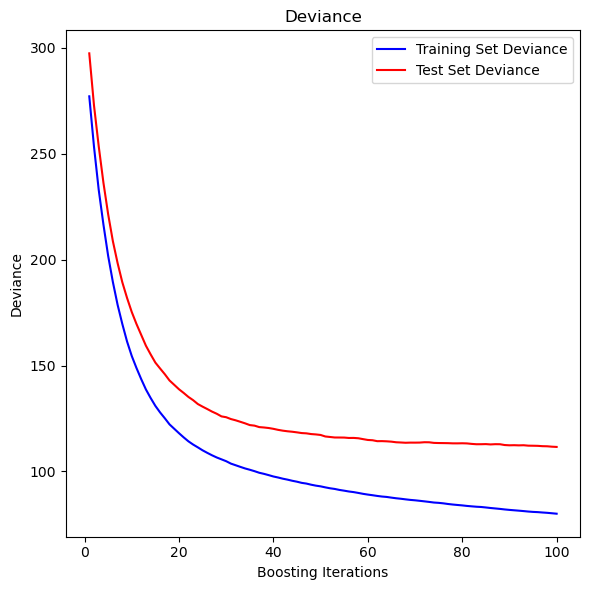

In [449]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(gbm.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    gbm.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

In [450]:
# factors_np = np.factors


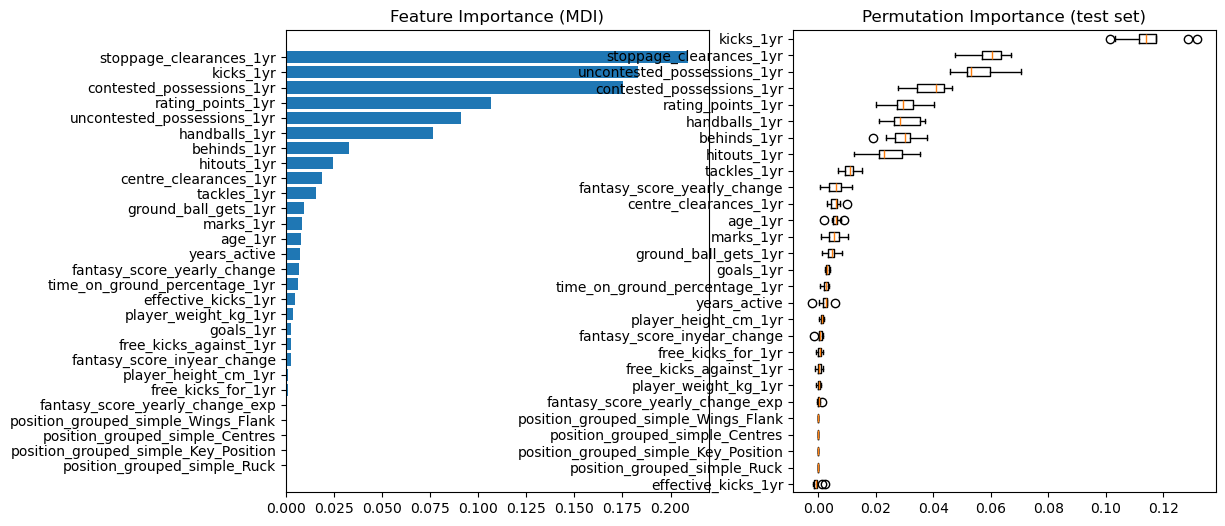

In [451]:
feature_importance = gbm.feature_importances_
sorted_idx = np.argsort(feature_importance)

## Col Names
X_train_cols = (X_train.keys())

pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X_train_cols)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    gbm, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X_train_cols)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
# fig.tight_layout()
plt.show()

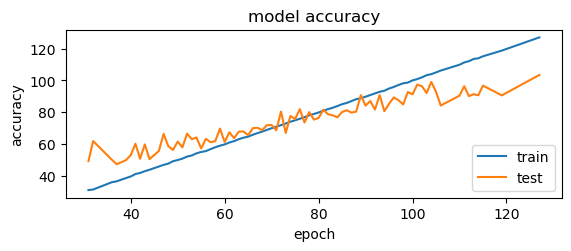

In [452]:
#comparing y-value actual and prediction of testing data
df_compare = pd.DataFrame({'Actual' : y_test, 'Prediction': y_pred})

model_output = df_compare.join(factors_load, lsuffix='_caller', rsuffix='_other', how='inner')

acc_chart = model_output.groupby(round(model_output['Actual'])).agg({'Prediction': 'mean', 'Actual': 'mean'})

# acc_chart.sort_values(by=['Actual'], ascending=True)

plt.subplot(2,1,1)
plt.plot(acc_chart['Actual'])
plt.plot(acc_chart['Prediction'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')


## Predict 2024 scores

In [453]:
# Make predictions
y_pred_new = gbm.predict(X_new)
y_pred_new = pd.DataFrame({'Predicted' : y_pred_new})

X_new_reset = X_new.reset_index()
factors_23_reset = factors_prep_23.reset_index()

pred_output = y_pred_new.join(factors_23_reset, lsuffix='_caller', rsuffix='_other', how='left')

# Write predictions to csv
# pred_output.to_csv(r'C:\Users\anoble\Git\Outside_Work\AFL Fantasy\Data\Outputs\Model_pred_GBM.csv')

print(factors_prep_23.shape)
print(X_new.shape)

(483, 173)
(483, 28)


In [454]:
## Sort by highest predicted score
pd.set_option('display.max_rows', 80)

pred_output['upside'] = pred_output['Predicted'] - pred_output['afl_fantasy_score_1yr']

pred_output[['player_name','age_1yr', 'position_grouped','matches_x','Predicted','afl_fantasy_score_1yr', 'upside']]\
.sort_values(by=['Predicted'], ascending=False).head(80)

# .query('position_grouped in "RUCK"')\

,player_name,age_1yr,position_grouped,matches_x,Predicted,afl_fantasy_score_1yr,upside
334,"Oliver, Clayton",26.0,C,15,114.259360,115.066667,-0.807307
37,"Bontempelli, Marcus",28.0,C,23,113.332175,116.956522,-3.624346
163,"Green, Tom",22.0,C,22,113.150210,108.727273,4.422938
300,"Merrett, Zach",28.0,C,22,112.492912,112.863636,-0.370724
396,"Serong, Caleb",22.0,C,22,112.288261,108.090909,4.197352
430,"Taranto, Tim",25.0,C,23,111.873135,112.434783,-0.561648
240,"Laird, Rory",30.0,C,22,110.841014,109.227273,1.613742
105,"Daicos, Nick",20.0,HBF,21,109.787370,111.809524,-2.022154
42,"Brayshaw, Andrew",24.0,C,23,109.365301,110.347826,-0.982525
347,"Petracca, Christian",27.0,C,25,109.270998,104.720000,4.550998


In [455]:
pred_output[['player_name','age_1yr', 'position_grouped','matches_x','Predicted','afl_fantasy_score_1yr', 'upside']]\
.sort_values(by=['upside'], ascending=False).query('Predicted >= 70').head(20)

,player_name,age_1yr,position_grouped,matches_x,Predicted,afl_fantasy_score_1yr,upside
460,"West, Connor",24.0,HFF,7,75.115615,47.571429,27.544187
185,"Hewett, Elijah",19.0,C,11,77.569900,52.545455,25.024446
157,"Ginbey, Reuben",19.0,W,15,85.679279,61.800000,23.879279
378,"Robertson, Deven",22.0,W,12,70.910506,48.666667,22.243840
474,"Worpel, James",24.0,C,23,108.373454,86.260870,22.112585
198,"Hollands, Elijah",21.0,FP,7,76.503463,55.142857,21.360606
213,"Hunter, Lachie",29.0,W,24,99.286978,78.333333,20.953645
153,"Fyfe, Nat",32.0,C,5,81.293005,60.800000,20.493005
349,"Petruccelle, Jack",24.0,FP,17,76.566154,56.705882,19.860272
211,"Humphrey, Bailey",19.0,FP,16,75.085619,55.562500,19.523119
